In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from time import time
import sys
import argparse
from pyspark import SparkContext
from operator import add
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
import pickle

In [2]:
def get_args(data, 
             folds, 
             reg = 1.0, 
             d = 10, 
             outputfile = 'output', 
             iter_num = 20, 
             N = 40, 
             master = 'local[40]'):
    import sys

    sys.argv = ['main',
                str(data),
                str(folds),
                '--reg', str(reg),
                '--d', str(d),
                '--outputfile', str(outputfile),
                '--iter', str(iter_num),
                '--N', str(N)]
    
    parser = argparse.ArgumentParser(
        description='Alternating least squares.', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('data', help='Directory containing folds. The folds should be named fold0, fold1, ..., foldK.')
    parser.add_argument('folds', type=int, help='Number of folds')
    parser.add_argument('--reg', default=1.0, type=float, help="Regularization parameter")
    parser.add_argument('--d', default=10, type=int, help="Number of latent features")
    parser.add_argument('--outputfile', help='Output file to save the model')
    parser.add_argument('--iter', default=20, type=int, help='Number of iterations to use during training')
    parser.add_argument('--N', default=40, type=int, help='Parallelization Level')

    verbosity_group = parser.add_mutually_exclusive_group(required=False)
    verbosity_group.add_argument('--verbose', dest='verbose', action='store_true')
    verbosity_group.add_argument('--silent', dest='verbose', action='store_false')
    parser.set_defaults(verbose=False)

    return parser.parse_args()
    return parser.parse_args()   

In [27]:
def readRatings(fileName, sparkContext, sess):
    """ 
        Read in ratings from a given file. 
        Assumes the file is a csv in the format (user, item, rating)
    """
    ratingsRDD = sparkContext.textFile(fileName).map(lambda x: tuple(x.split(',')))\
        .map(lambda (user, item, rating): Row(userId=int(user), itemId=int(item), rating=float(rating)))
    return sess.createDataFrame(ratingsRDD)

def readFolds(directory, numFolds, sc, sess):
    """
        Reads folds of data from a directory.
        Assumes files are formatted with "fold[i]" where i is the fold number
    """
    folds = {}
    if numFolds == 1:
        numFolds = 5
    for k in range(numFolds):
        folds[k] = readRatings(directory+"/fold"+str(k), sc, sess).persist()
    return folds

def createTrainTestData(folds, k, N, numFolds):
    """
        Generates test and train data with the given fold object and value for k.
        k represents the fold to use for testing, while all other folds will be used for training.
    """
    if numFolds == 1:
        k = -1
    train_folds = [folds[j] for j in folds if j is not k]
    train = train_folds[0]
    for fold in train_folds[1:]:
        train = train.union(fold)
    train = train.repartition(N).cache()
    if numFolds == 1:
        test = train
    else:
        test = folds[k].repartition(N).cache()
    return train, test

In [26]:
def train(args, sc, sess, folds, numFolds):
#     folds = readFolds(args.data, args.folds, sc, sess)
    cross_val_rmses = []
    model = None
    for k in range(numFolds):
        train, test = createTrainTestData(folds, k, args.N, numFolds)
        print"Initiating fold %d with %d train samples and %d test samples" % (k, train.count(), test.count())
        train.persist()
        test.persist()
        start = time()
        als = ALS(numUserBlocks=args.N,
                  numItemBlocks=args.N,
                  maxIter=args.iter,
                  rank=args.d,
                  regParam=args.reg, 
                  userCol="userId", 
                  itemCol="itemId", 
                  ratingCol="rating", 
                  coldStartStrategy='drop')
        model = als.fit(train)
        predictions = model.transform(test)
        predictions.show()
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
        testRMSE = evaluator.evaluate(predictions)

        now = time()-start
        print "Fold: %d\tTime: %f\tTestRMSE: %f" % (k, now, testRMSE)

        cross_val_rmses.append(testRMSE)
#         train.unpersist()
#         test.unpersist()

    print "%d-fold cross validation error is: %f " % (args.folds, np.mean(cross_val_rmses))
    return np.mean(cross_val_rmses), model

In [20]:
SparkContext.setSystemProperty('spark.executor.memory', '100g')
SparkContext.setSystemProperty('spark.driver.memory', '100g')
try:
    sc = SparkContext('local[40]', appName='Parallel MF')
except:
    sc = SparkContext.getOrCreate()
    SparkContext.stop(sc)
    sc = SparkContext('local[40]', appName='Parallel MF')
spark = SparkSession(sc)
sc.setLogLevel("ERROR")   
sc.setCheckpointDir('checkpoint/')
sess = SparkSession(sc)

In [8]:
# SparkContext.stop(sc)
SparkContext.setSystemProperty('spark.executor.memory', '100g')
SparkContext.setSystemProperty('spark.driver.memory', '100g')
sc = SparkContext("spark://10.99.248.39:7077", appName='Parallel MF')
sc.setCheckpointDir('checkpoint/')
sc.setLogLevel("ERROR")   
sess = SparkSession(sc)

In [25]:
data = '../data/beer'
num_folds = 1
reg = 0.08
d = 20
outputfile = 'output'
iter_num = 100
N = 64
folds = readFolds(data, num_folds, sc, sess)
results = []
# for reg in range(1, 2):
#     for d in range(2, 3):

print('---------------------------------------')
print('reg: {}, d: {}'.format(reg, d))
args = get_args(data, num_folds, reg, d, outputfile, iter_num, N)
rms, model = train(args, sc, sess, folds, num_folds)
results.append((reg, d, rms))
with open('../results/als/beer_0.08_20.pickle', 'wb+') as f:
    pickle.dump(results, f)
with open('../results/als/beer_0.08_20.txt', 'ab+') as f:
    f.write('{} {} {}\n'.format(reg, d, rms))

---------------------------------------
reg: 0.08, d: 20
('num', 1)
1518478
Initiating fold 0 with 1518478 train samples and 1518478 test samples
+------+------+------+----------+
|itemId|rating|userId|prediction|
+------+------+------+----------+
|   148|   4.0| 20735|  4.006267|
|   148|   4.0| 26623| 3.9464264|
|   148|   4.5| 13483| 4.0471444|
|   148|   5.0| 28316|  4.325294|
|   148|   4.0|  7661| 4.2432847|
|   148|   4.0| 11520| 4.1579204|
|   148|   4.0| 12210| 3.8142867|
|   148|   3.5| 27941|  3.233887|
|   148|   4.5| 29061| 4.1278186|
|   148|   4.0| 30333|  4.107945|
|   148|   4.0|  1718| 4.0349684|
|   148|   4.0|  4799| 3.9945402|
|   148|   4.0|  8409| 3.9048324|
|   148|   4.5| 10128| 4.2409253|
|   148|   4.5|  2971|  4.123874|
|   148|   5.0|  7817| 4.6692333|
|   148|   4.0| 14437| 3.6649663|
|   148|   4.5| 17525|  4.098264|
|   148|   4.5| 19358| 4.0919857|
|   148|   5.0| 10898| 4.0474453|
+------+------+------+----------+
only showing top 20 rows

Fold: 0	Time

In [43]:
u_str = model.userFactors.rdd.map(lambda (x, y): ','.join(str(t) for t in [x] + list(y)))
v_str = model.itemFactors.rdd.map(lambda (x, y): ','.join(str(t) for t in [x] + list(y)))

In [44]:
u_str.saveAsTextFile('../results/als/u.csv')
v_str.saveAsTextFile('../results/als/v.csv')

In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# with open('/scratch/liu.che/ParallelProcessingFinal/results/als/{}_results_d_search.pickle'.format('large_data'), 'rb') as f:
with open('/scratch/liu.che/ParallelProcessingFinal/results/als/beer.pickle', 'rb') as f:
    res = pickle.load(f)
    df = pd.DataFrame()
#     df = pd.DataFrame({
#         'lam': list(range(9)),
#         'mu': list(range(9)),
#         'd': [4] * 9,
#         'rms': [105.232653602, 105.243649287, 105.260565961, 105.283086419, 105.310910376, 105.343753562, 
#                105.381346878, 105.423435582, 105.469778531],
#     })

for r in res:
    reg, d, rms = r
    df = df.append({'reg': reg, 'd': d, 'rms': rms}, ignore_index = True)
    

In [4]:
df.loc[df.rms == df.rms.min()]

,d,reg,rms
3,20.0,0.08,0.610734


In [6]:
ax = df.loc[df.reg == 1].plot(x = 'd', y = 'rms', figsize=(10, 10), fontsize = 20)
ax.legend().remove()
plt.title('small data | reg = 1, max iter = 30', fontsize = 20)
plt.xlabel('d', fontsize = 20)
plt.ylabel('rms', fontsize = 20)

TypeError: Empty 'DataFrame': no numeric data to plot

Text(0,0.5,'rms')

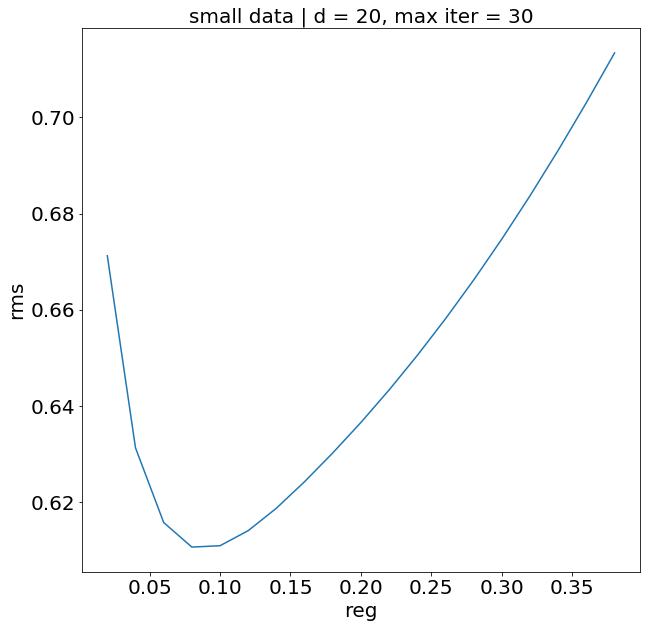

In [7]:
ax = df.plot(x = 'reg', y = 'rms', figsize=(10, 10), fontsize = 20)
ax.legend().remove()
plt.title('small data | d = 20, max iter = 30', fontsize = 20)
plt.xlabel('reg', fontsize = 20)
plt.ylabel('rms', fontsize = 20)